# integrating scRNA-seq and ADT counts with VIMCCA
This tutorial shows loading, preprocessing, VIMCCA joint analyse of multimodal dataset.

## import packages
Here, we’ll import scbean along with other popular packages.

In [1]:
import matplotlib
matplotlib.use('TkAgg')
import scanpy as sc
from scbean.model import vimcca

# Command for Jupyter Notebooks only
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

Using TensorFlow backend.


## loading dataset
This use the CITE-seq dataset from [(Stuart*, Butler* et al, Cell 2019)](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8), which consists of 30,672 scRNA-seq profiles measured alongside a panel of 25 antibodies from bone marrow. The object contains two assays, RNA and antibody-derived tags (ADT).

In [2]:
base_path = '/Users/wangyuwei/data/'
file_rna = base_path + 'bmcite_rna.h5ad'
file_atac = base_path + 'bmcite_adt.h5ad'

adata_rna = sc.read_h5ad(file_rna)
adata_adt = sc.read_h5ad(file_atac)

## Processing with scanpy
Here, we filter genes that expressed in less than ten cells. We then apply CPM normalization for each cell so that every cell have same total count after normalization. Finally, we performed a log transformation. As for ADT count data, we p erformed the same op erations excepting for ltering genes since there are only 25 proteins

In [3]:
# filter genes
sc.pp.filter_genes(adata_rna, min_cells=10)
# CMP
sc.pp.normalize_total(adata_rna, target_sum=1e6)
sc.pp.normalize_total(adata_adt, target_sum=1e6)
# log transformation
sc.pp.log1p(adata_rna)
sc.pp.log1p(adata_adt)
# scale genes to unit variance
sc.pp.scale(adata_rna)
sc.pp.scale(adata_adt)

## Joint analyse using VIMCCA
The returned z represents the complementary low-dimensional features of the two modalities learned by VIMCCA, which can be used for downstream analysis.

In [4]:
z = vimcca.fit_integration(
    adata_rna,
    adata_adt,
    sparse_x=False,
    sparse_y=False,
    hidden_layers=[128, 64, 16, 8],
    epochs=50,
    weight=5
)

Model: "VIMCCA_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_x (InputLayer)           [(None, 16313)]      0                                            
__________________________________________________________________________________________________
encoder_z (Functional)          [(None, 8), (None, 8 2098384     inputs_x[0][0]                   
                                                                 inputs_x[0][0]                   
__________________________________________________________________________________________________
inputs_y (InputLayer)           [(None, 25)]         0                                            
__________________________________________________________________________________________________
decoder_x (Functional)          (None, 16313)        2114553     encoder_z[0][2]         

240/240 [==============================] - 23s 81ms/step - loss: 8284.0040
Epoch 2/50
240/240 [==============================] - 19s 81ms/step - loss: 8028.0267
Epoch 3/50
240/240 [==============================] - 19s 80ms/step - loss: 7961.8807
Epoch 4/50
240/240 [==============================] - 20s 84ms/step - loss: 7930.2967
Epoch 5/50
240/240 [==============================] - 20s 85ms/step - loss: 7916.6656
Epoch 6/50
240/240 [==============================] - 18s 77ms/step - loss: 7934.1473
Epoch 7/50
240/240 [==============================] - 21s 88ms/step - loss: 7906.9380
Epoch 8/50
240/240 [==============================] - 25s 103ms/step - loss: 7889.3803
Epoch 9/50
240/240 [==============================] - 23s 98ms/step - loss: 7913.1959
Epoch 10/50
240/240 [==============================] - 22s 90ms/step - loss: 7932.7211
Epoch 11/50
240/240 [==============================] - 23s 94ms/step - loss: 7891.7655
Epoch 12/50
240/240 [==============================] - 22s 91m

## Visualization

In [5]:
adata_rna.obsm['X_vimcca'] = z
sc.pp.neighbors(adata_rna, use_rep='X_vimcca')
sc.tl.leiden(adata_rna, resolution=3)
sc.tl.umap(adata_rna)

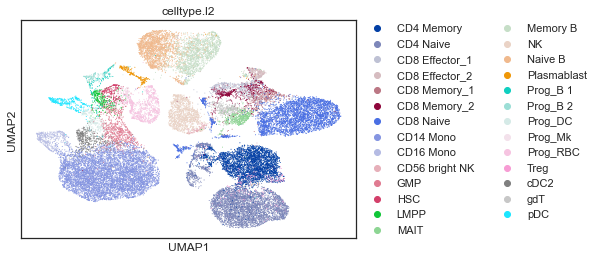

In [6]:
sc.pl.umap(adata_rna, color='celltype.l2')

We can explore marker genes

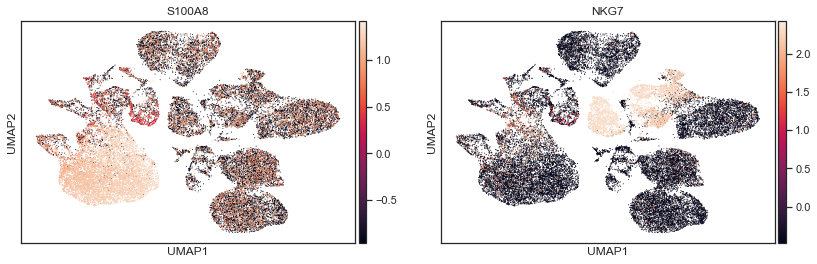

In [7]:
sc.pl.umap(adata_rna, color=['S100A8', 'NKG7'])